# Project 2: Linear Classification

### Part 1: Generate Training and Testing Data (2 points)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import exit
import math

plt.close()

#-----------Part 1----------------

# Generating Training and Testing Data
# Creating a class for the dataset
class Data_set:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov  = cov
    
    def split_data(self):
        np.random.shuffle(self.data)
        self.train = self.data[:len(self.data)//2]
        self.test  = self.data[len(self.data)//2:]
        
        return self
    
    def multivariate_normal(self, num):
        # asself.data.shape = num *  2
        self.data = np.random.multivariate_normal(self.mean,self.cov,size=num)
    
        return self
    
# def lda_accuracy(data, w, b):
#     false_count = 0
#     miss_data    = []
#     for index, item in enumerate(data):
#         lda_val = np.dot(w,item)
#         # class c1
#         if index<100 and lda_val<0:
#             false_count = false_count + 1
#             miss_data   = np.append(miss_data, item)
#         # class c2    
#         elif index>=100 and lda_val>=0:
#             false_count = false_count + 1
#             miss_data   = np.append(miss_data, item)
    
#     accuracy = 1 - false_count/len(data)
#     miss_data = miss_data.reshape(int(len(miss_data)/2),2)
# #     print(miss_data.shape)
    
#     return accuracy, miss_data
    
def accuracy(c1, c2, w, b, var):
    # Calculating accuracy of learned model
    # Using generated data
    acc_c1 = []
    acc_c2 = []
    miss = []
    
    for item in c1:
        bool_c1 = point_loc(item, c1, w, b, var)
        acc_c1.append(bool_c1)
        if not bool_c1:
            miss = np.append(miss, item)
    
    for item in c2:
        bool_c2 = point_loc(item, c2, w, b, var)
        acc_c2.append(bool_c2)
        if bool_c2:
            miss = np.append(miss, item)
        
    acc = (sum(acc_c1)+(100-sum(acc_c2)))/200
    miss = miss.reshape(len(miss)//2, 2)
        
    return acc, miss
    
def gen_line_vec(data_set, w, b, var):
    # var = W.dot(data_set) + b
    # var = 0 when plotting line for LDA
    # var = 0.5 when plotting line for LR
    
    # Find the min and max value on x axis
    mini = min(data_set[:,0])
    maxi = max(data_set[:,0])
    
    # generating x axis vector (step size 0.1)
    x_vec = np.arange(mini, maxi, 0.1)
    
    # calculating y vector
    y_vec = (-var-b-w[0]*x_vec)/w[1]
    
    return x_vec, y_vec

def point_loc(point, data, w, b, var):
    # var = W.dot(data_set) + b
    # var = 0 when plotting line for LDA
    # var = 0.5 when plotting line for LR
    
    _x, _y = gen_line_vec(data, w, b, var)
    point_a = np.array([_x[0],_y[0]])
    point_b = np.array([_x[-1],_y[-1]])
    
    cross_prod = np.cross(point-point_a, point_b-point_a)
    
    result = (cross_prod < 0) # less than 0 when a point is above the divider
    
    return result
  

In [2]:
#### Given parameters
mean1 = np.array([1,1])
mean2 = np.array([-1,-1])
cov1 = np.array([[3,2],[2,3]])
cov2 = np.array([[2,-1],[-1,2]])

#### Generating dataset and spliting dataset
c1 = Data_set(mean1,cov1)
c1 = c1.multivariate_normal(200)
c1 = c1.split_data()
# c1.train, c1.test
c2 = Data_set(mean2,cov2)
c2 = c2.multivariate_normal(200)
c2 = c2.split_data()


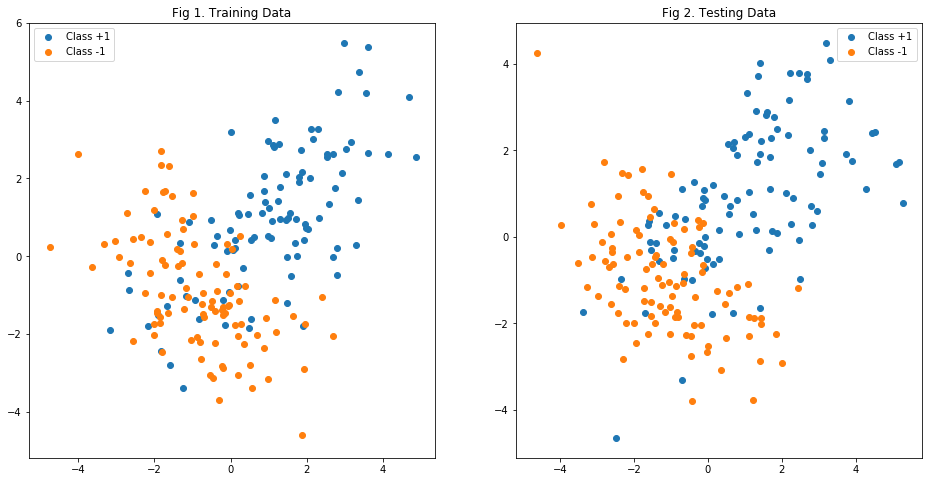

In [3]:
#---PLOT---
fig = plt.figure(1, figsize=(16,8))
fig.clf()
ax_train = fig.add_subplot(121)
ax_train.scatter(c1.train[:,0], c1.train[:,1], label="Class +1")
ax_train.scatter(c2.train[:,0], c2.train[:,1], label="Class -1")
ax_train.legend()
ax_train.set_title("Fig 1. Training Data")

ax_test  = fig.add_subplot(122)
ax_test.scatter(c1.test[:,0], c1.test[:,1], label="Class +1")
ax_test.scatter(c2.test[:,0], c2.test[:,1], label="Class -1")
ax_test.legend()
ax_test.set_title("Fig 2. Testing Data")
plt.show()

### Part 2: Linear Discriminant Analysis (5 points)

In [4]:
#-------------Part 2----------------

# Overall mean & covariance
train_data = np.vstack((c1.train, c2.train))
test_data  = np.vstack((c1.test, c2.test))
# mu_est     = [np.mean(train_data[:,0]),np.mean(train_data[:,1])]
cov_est    = np.cov(test_data.T)   # Transopose data to get correct covariance


In [5]:
# Finding weight(w) vector
# w = (mu1 - mu2)*cov_est^T
sample_mean_c1 = np.array([np.mean(c1.train[:,0]),np.mean(c1.train[:,1])])
sample_mean_c2 = np.array([np.mean(c2.train[:,0]),np.mean(c2.train[:,1])])
w              = np.dot((sample_mean_c1 - sample_mean_c2),cov_est**-1)

pi_1           = len(c1.test)/len(test_data)
pi_2           = len(c2.test)/len(test_data)
# First two terms of bias
term1          = 0.5*np.dot(np.dot(sample_mean_c1.T, np.linalg.inv(cov_est)),sample_mean_c1)
term2          = 0.5*np.dot(np.dot(sample_mean_c2.T, np.linalg.inv(cov_est)),sample_mean_c2)

b              = term1 - term2 + np.log(pi_2/pi_1)

-----LDA-----
The estimate overall covariance is [[3.82258268 1.45102009]
 [1.45102009 3.12605171]]
Learned weight w is [1.78383846 1.9117661 ]
Learned bias b is 0.053967227694796116
The accuracy is 0.82


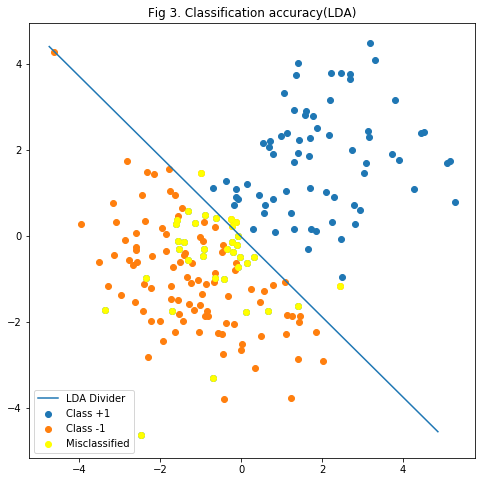

In [10]:
# Classify the test data
x_axis, y_axis = gen_line_vec(train_data, w, b, 0)

acc, miss = accuracy(c1.test, c2.test, w, b, 0)

print("-----LDA-----")
# print("The estimate overall mean is", mu_est)
print("The estimate overall covariance is", cov_est)

print("Learned weight w is", w)
print("Learned bias b is", b)

print("The accuracy is", acc)

#---PLOT---
fig2 = plt.figure(2,figsize=(8,8))
fig2.clf()
ax2 = fig2.add_subplot(111)
ax2.scatter(c1.test[:,0], c1.test[:,1], label="Class +1")
ax2.scatter(c2.test[:,0], c2.test[:,1], label="Class -1")
ax2.scatter(miss[:,0], miss[:,1], label="Misclassified",c="yellow")
ax2.plot(x_axis,y_axis,label="LDA Divider")
ax2.legend()
ax2.set_title("Fig 3. Classification accuracy(LDA)")
plt.show()

### Part 3: Logistic Regression (10 points)

In [7]:
#-------------Part 3----------------

# Lump a '1' into each data point
ones          = np.ones(len(train_data))[None].T
train_data_1s = np.hstack((ones, train_data))

In [12]:
def IRLS(data):
    length        = len(data)
    not_converged = True
    w             = np.array([0, 0, 0])
    p             = np.empty(length)
    s             = np.empty(length)
    z             = np.empty(length)

    ones = np.ones(200)
    ones[100:] = ones[100:]*-1
    
    temp_var = np.hstack((ones[None].T,data))
    np.random.shuffle(temp_var)
    
    y = temp_var[:,0]
    data = temp_var[:,1:]
    
    while not_converged:
        w_prev = w
        for i in range(length):
            p[i] = np.exp(w_prev.dot(data[i])) / (1 + np.exp(w_prev.dot(data[i])))
            #p[i] = 1-(1 / (1 + np.exp(w.dot(data[i]))))                
            s[i] = p[i]*(1-p[i])
            if math.isnan(s[i]): s[i]=1
            z[i] = w_prev.dot(data[i]) + (y[i]-p[i])/(max(s[i],0.00001))
            #print(i,'---',p[i],s[i],z[i])
        diag_s = np.diag(s)
        t1     = np.linalg.inv(np.dot(np.dot(data.T, diag_s), data))
        t2     = np.dot(np.dot(data.T, diag_s), z)
        w      = np.dot(t1, t2)
        w      = w/np.linalg.norm(w)
        
        print('Iterations',w)
        
        if abs(sum(w-w_prev)) < 0.000001:
            
            print("Converged!!")
            not_converged = False
            return w
            
        elif sum(abs(w)) > 900 or math.isnan(w[0]):
            
            print("Not converging!!!")
            return w
            
    return w

Iterations [-0.88162885  0.36632505  0.2975509 ]
Iterations [-0.8733885   0.38659009  0.29621045]
Iterations [-0.87097035  0.39371717  0.29393442]
Iterations [-0.87027919  0.39638193  0.29239614]
Iterations [-0.87008795  0.39743389  0.29153604]
Iterations [-0.87003776  0.39786942  0.29109143]
Iterations [-0.8700259   0.39805684  0.29087055]
Iterations [-0.87002379  0.39813987  0.29076322]
Iterations [-0.87002382  0.39817741  0.29071173]
Iterations [-0.87002413  0.39819463  0.29068721]
Iterations [-0.87002436  0.3982026   0.29067559]
Iterations [-0.8700245   0.39820631  0.29067011]
Iterations [-0.87002457  0.39820804  0.29066752]
Converged!!
-----LR-----
Bias: -0.8700245676417444
Weight: [0.39820804 0.29066752]
Accuracy 0.8


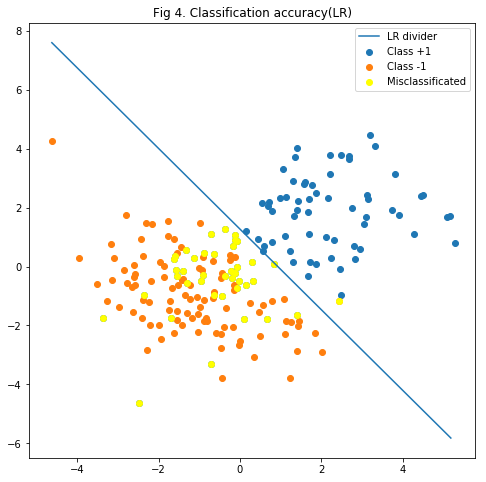

In [13]:
# train_data_1s.T.shape
#print("-----LDA-----")
#print("Bias:",b,"W:",w)
re = IRLS(train_data_1s)
print("-----LR-----")
print("Bias:",re[0])
print("Weight:",re[1:])
acc, miss = accuracy(c1.test, c2.test, re[1:], re[0], 0.5)
print("Accuracy", acc)

#---PLOT---
_x,_y = gen_line_vec(test_data, re[1:], re[0], 0.5)
f4 = plt.figure(4,figsize=(8,8))
f4.clf()
ax4 = f4.add_subplot(111)
ax4.scatter(c1.test[:,0], c1.test[:,1], label="Class +1")
ax4.scatter(c2.test[:,0], c2.test[:,1], label="Class -1")
ax4.scatter(miss[:,0],miss[:,1], label="Misclassificated", c="yellow")
ax4.plot(_x, _y, label='LR divider')
ax4.legend()
ax4.set_title("Fig 4. Classification accuracy(LR)")
plt.show()

# exit()

# Quadratic Discriminant Analysis (+3 points)